## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [4]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
#!mkdir /data
#!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
#!unzip -n ./data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [5]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
#from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=136, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                        RandomCrop(224),
                                        Normalize(),
                                        ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [8]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/Users/paul/git/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [9]:
# load training data in batches
batch_size = 1

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [10]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [11]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [30]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor) #int64 to train, FloatTensor to test

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [13]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

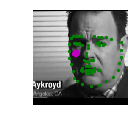

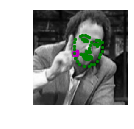

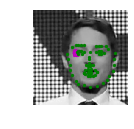

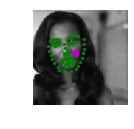

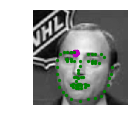

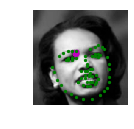

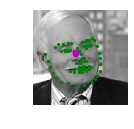

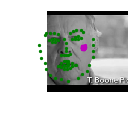

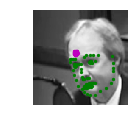

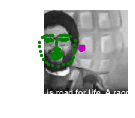

In [19]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [26]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [22]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("starting epoch "+str(epoch))
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print("starting batch "+str(batch_i))
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                
            #if batch_i == 500:
            #    break

    print('Finished Training')


In [48]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
train_net(n_epochs)

starting epoch 0
Epoch: 1, Batch: 10, Avg. Loss: 0.12066524904221296
Epoch: 1, Batch: 20, Avg. Loss: 0.1072715195827186
Epoch: 1, Batch: 30, Avg. Loss: 0.16556884087622165
Epoch: 1, Batch: 40, Avg. Loss: 0.08373119980096817
Epoch: 1, Batch: 50, Avg. Loss: 0.07508925078436732
Epoch: 1, Batch: 60, Avg. Loss: 0.05981498472392559
Epoch: 1, Batch: 70, Avg. Loss: 0.09848499707877637
Epoch: 1, Batch: 80, Avg. Loss: 0.16342632276937366
Epoch: 1, Batch: 90, Avg. Loss: 0.08980304794386029
Epoch: 1, Batch: 100, Avg. Loss: 0.12007821695879102
Epoch: 1, Batch: 110, Avg. Loss: 0.08138299304991961
Epoch: 1, Batch: 120, Avg. Loss: 0.08144676480442285
Epoch: 1, Batch: 130, Avg. Loss: 0.11667207032442092
Epoch: 1, Batch: 140, Avg. Loss: 0.13545862957835197
Epoch: 1, Batch: 150, Avg. Loss: 0.19836144037544728
Epoch: 1, Batch: 160, Avg. Loss: 0.09098638067953288
Epoch: 1, Batch: 170, Avg. Loss: 0.08482428030110896
Epoch: 1, Batch: 180, Avg. Loss: 0.13778758104890584
Epoch: 1, Batch: 190, Avg. Loss: 0.1151

Epoch: 1, Batch: 1550, Avg. Loss: 0.08721749782562256
Epoch: 1, Batch: 1560, Avg. Loss: 0.11003759549930692
Epoch: 1, Batch: 1570, Avg. Loss: 0.07344534024596214
Epoch: 1, Batch: 1580, Avg. Loss: 0.06957882475107909
Epoch: 1, Batch: 1590, Avg. Loss: 0.1353429935872555
Epoch: 1, Batch: 1600, Avg. Loss: 0.12163606025278569
Epoch: 1, Batch: 1610, Avg. Loss: 0.08220890727825463
Epoch: 1, Batch: 1620, Avg. Loss: 0.0917721340432763
Epoch: 1, Batch: 1630, Avg. Loss: 0.077372345328331
Epoch: 1, Batch: 1640, Avg. Loss: 0.09360058847814798
Epoch: 1, Batch: 1650, Avg. Loss: 0.09769584238529205
Epoch: 1, Batch: 1660, Avg. Loss: 0.09687756635248661
Epoch: 1, Batch: 1670, Avg. Loss: 0.04836678830906749
Epoch: 1, Batch: 1680, Avg. Loss: 0.13412902411073446
Epoch: 1, Batch: 1690, Avg. Loss: 0.07395163725595921
Epoch: 1, Batch: 1700, Avg. Loss: 0.1437987219542265
Epoch: 1, Batch: 1710, Avg. Loss: 0.11932370588183402
Epoch: 1, Batch: 1720, Avg. Loss: 0.19890981325879692
Epoch: 1, Batch: 1730, Avg. Loss:

Epoch: 1, Batch: 3080, Avg. Loss: 0.07979134265333414
Epoch: 1, Batch: 3090, Avg. Loss: 0.07523767007514834
Epoch: 1, Batch: 3100, Avg. Loss: 0.0793382715433836
Epoch: 1, Batch: 3110, Avg. Loss: 0.08976432122290134
Epoch: 1, Batch: 3120, Avg. Loss: 0.09543522410094737
Epoch: 1, Batch: 3130, Avg. Loss: 0.056499723065644505
Epoch: 1, Batch: 3140, Avg. Loss: 0.08330041309818625
Epoch: 1, Batch: 3150, Avg. Loss: 0.11535262353718281
Epoch: 1, Batch: 3160, Avg. Loss: 0.09903579642996192
Epoch: 1, Batch: 3170, Avg. Loss: 0.08556570671498775
Epoch: 1, Batch: 3180, Avg. Loss: 0.09066612338647247
Epoch: 1, Batch: 3190, Avg. Loss: 0.11957578845322132
Epoch: 1, Batch: 3200, Avg. Loss: 0.10549751073122024
Epoch: 1, Batch: 3210, Avg. Loss: 0.12746203569695352
Epoch: 1, Batch: 3220, Avg. Loss: 0.09152607601135969
Epoch: 1, Batch: 3230, Avg. Loss: 0.08759317630901933
Epoch: 1, Batch: 3240, Avg. Loss: 0.11120352614670992
Epoch: 1, Batch: 3250, Avg. Loss: 0.21647968757897615
Epoch: 1, Batch: 3260, Avg. 

Epoch: 2, Batch: 1160, Avg. Loss: 0.08087590103968978
Epoch: 2, Batch: 1170, Avg. Loss: 0.06760029857978225
Epoch: 2, Batch: 1180, Avg. Loss: 0.12379549536854029
Epoch: 2, Batch: 1190, Avg. Loss: 0.11333020199090242
Epoch: 2, Batch: 1200, Avg. Loss: 0.1095236074179411
Epoch: 2, Batch: 1210, Avg. Loss: 0.09937855470925569
Epoch: 2, Batch: 1220, Avg. Loss: 0.10830560699105263
Epoch: 2, Batch: 1230, Avg. Loss: 0.12009888216853142
Epoch: 2, Batch: 1240, Avg. Loss: 0.15500257462263106
Epoch: 2, Batch: 1250, Avg. Loss: 0.11768424231559038
Epoch: 2, Batch: 1260, Avg. Loss: 0.1661738157272339
Epoch: 2, Batch: 1270, Avg. Loss: 0.057395995035767554
Epoch: 2, Batch: 1280, Avg. Loss: 0.08924070121720433
Epoch: 2, Batch: 1290, Avg. Loss: 0.15117067582905291
Epoch: 2, Batch: 1300, Avg. Loss: 0.06030386500060558
Epoch: 2, Batch: 1310, Avg. Loss: 0.15443815235048533
Epoch: 2, Batch: 1320, Avg. Loss: 0.12202363675460219
Epoch: 2, Batch: 1330, Avg. Loss: 0.07067859936505556
Epoch: 2, Batch: 1340, Avg. L

Epoch: 2, Batch: 2680, Avg. Loss: 0.053472095355391505
Epoch: 2, Batch: 2690, Avg. Loss: 0.052035376988351346
Epoch: 2, Batch: 2700, Avg. Loss: 0.05105571132153273
Epoch: 2, Batch: 2710, Avg. Loss: 0.05371956313028932
Epoch: 2, Batch: 2720, Avg. Loss: 0.08099484196864068
Epoch: 2, Batch: 2730, Avg. Loss: 0.10595210902392864
Epoch: 2, Batch: 2740, Avg. Loss: 0.06038916232064366
Epoch: 2, Batch: 2750, Avg. Loss: 0.09061541501432657
Epoch: 2, Batch: 2760, Avg. Loss: 0.0901551772840321
Epoch: 2, Batch: 2770, Avg. Loss: 0.036363582499325274
Epoch: 2, Batch: 2780, Avg. Loss: 0.0625990888569504
Epoch: 2, Batch: 2790, Avg. Loss: 0.2116110125556588
Epoch: 2, Batch: 2800, Avg. Loss: 0.20870797540992497
Epoch: 2, Batch: 2810, Avg. Loss: 0.0585433186031878
Epoch: 2, Batch: 2820, Avg. Loss: 0.07685155076906085
Epoch: 2, Batch: 2830, Avg. Loss: 0.14397241342812778
Epoch: 2, Batch: 2840, Avg. Loss: 0.11908128540962934
Epoch: 2, Batch: 2850, Avg. Loss: 0.064836984872818
Epoch: 2, Batch: 2860, Avg. Los

Epoch: 3, Batch: 760, Avg. Loss: 0.09699275828897953
Epoch: 3, Batch: 770, Avg. Loss: 0.1501073097810149
Epoch: 3, Batch: 780, Avg. Loss: 0.1059232896193862
Epoch: 3, Batch: 790, Avg. Loss: 0.05875569004565477
Epoch: 3, Batch: 800, Avg. Loss: 0.13444447899237275
Epoch: 3, Batch: 810, Avg. Loss: 0.103905132971704
Epoch: 3, Batch: 820, Avg. Loss: 0.071916713565588
Epoch: 3, Batch: 830, Avg. Loss: 0.1045001681894064
Epoch: 3, Batch: 840, Avg. Loss: 0.18021305585280062
Epoch: 3, Batch: 850, Avg. Loss: 0.09929322069510818
Epoch: 3, Batch: 860, Avg. Loss: 0.07284887973219156
Epoch: 3, Batch: 870, Avg. Loss: 0.05523941544815898
Epoch: 3, Batch: 880, Avg. Loss: 0.055842768587172034
Epoch: 3, Batch: 890, Avg. Loss: 0.054448314011096954
Epoch: 3, Batch: 900, Avg. Loss: 0.06371253682300448
Epoch: 3, Batch: 910, Avg. Loss: 0.04062340427190066
Epoch: 3, Batch: 920, Avg. Loss: 0.07715416252613068
Epoch: 3, Batch: 930, Avg. Loss: 0.04724132167175412
Epoch: 3, Batch: 940, Avg. Loss: 0.0729578701779246

Epoch: 3, Batch: 2290, Avg. Loss: 0.11264011729508638
Epoch: 3, Batch: 2300, Avg. Loss: 0.1297189325094223
Epoch: 3, Batch: 2310, Avg. Loss: 0.03207965358160436
Epoch: 3, Batch: 2320, Avg. Loss: 0.04088434223085642
Epoch: 3, Batch: 2330, Avg. Loss: 0.0637921643909067
Epoch: 3, Batch: 2340, Avg. Loss: 0.07201888523995877
Epoch: 3, Batch: 2350, Avg. Loss: 0.04270947650074959
Epoch: 3, Batch: 2360, Avg. Loss: 0.08473083921708166
Epoch: 3, Batch: 2370, Avg. Loss: 0.05347106507979334
Epoch: 3, Batch: 2380, Avg. Loss: 0.12966269329190255
Epoch: 3, Batch: 2390, Avg. Loss: 0.08617118671536446
Epoch: 3, Batch: 2400, Avg. Loss: 0.061375103890895844
Epoch: 3, Batch: 2410, Avg. Loss: 0.05233884481713176
Epoch: 3, Batch: 2420, Avg. Loss: 0.1055777609348297
Epoch: 3, Batch: 2430, Avg. Loss: 0.18881930448114873
Epoch: 3, Batch: 2440, Avg. Loss: 0.05646738475188613
Epoch: 3, Batch: 2450, Avg. Loss: 0.03517268081195653
Epoch: 3, Batch: 2460, Avg. Loss: 0.07567269187420607
Epoch: 3, Batch: 2470, Avg. Lo

Epoch: 4, Batch: 350, Avg. Loss: 0.026873243460431694
Epoch: 4, Batch: 360, Avg. Loss: 0.04013185389339924
Epoch: 4, Batch: 370, Avg. Loss: 0.05641843564808369
Epoch: 4, Batch: 380, Avg. Loss: 0.24228227655403317
Epoch: 4, Batch: 390, Avg. Loss: 0.09033156856894493
Epoch: 4, Batch: 400, Avg. Loss: 0.04186654575169087
Epoch: 4, Batch: 410, Avg. Loss: 0.07292706333100796
Epoch: 4, Batch: 420, Avg. Loss: 0.0811739070340991
Epoch: 4, Batch: 430, Avg. Loss: 0.10301775354892015
Epoch: 4, Batch: 440, Avg. Loss: 0.09055313942953944
Epoch: 4, Batch: 450, Avg. Loss: 0.044065890554338696
Epoch: 4, Batch: 460, Avg. Loss: 0.03826318485662341
Epoch: 4, Batch: 470, Avg. Loss: 0.08129489915445447
Epoch: 4, Batch: 480, Avg. Loss: 0.07960297046229244
Epoch: 4, Batch: 490, Avg. Loss: 0.09272801610641182
Epoch: 4, Batch: 500, Avg. Loss: 0.06341701000928879
Epoch: 4, Batch: 510, Avg. Loss: 0.07201356459408999
Epoch: 4, Batch: 520, Avg. Loss: 0.03396524027921259
Epoch: 4, Batch: 530, Avg. Loss: 0.0258484901

Epoch: 4, Batch: 1880, Avg. Loss: 0.029020173382014035
Epoch: 4, Batch: 1890, Avg. Loss: 0.027772645745426417
Epoch: 4, Batch: 1900, Avg. Loss: 0.04336204882711172
Epoch: 4, Batch: 1910, Avg. Loss: 0.07123881634324788
Epoch: 4, Batch: 1920, Avg. Loss: 0.02599630397744477
Epoch: 4, Batch: 1930, Avg. Loss: 0.04452791942749172
Epoch: 4, Batch: 1940, Avg. Loss: 0.02256560535170138
Epoch: 4, Batch: 1950, Avg. Loss: 0.06399204446934163
Epoch: 4, Batch: 1960, Avg. Loss: 0.06589384507387877
Epoch: 4, Batch: 1970, Avg. Loss: 0.027185381343588232
Epoch: 4, Batch: 1980, Avg. Loss: 0.0359759917948395
Epoch: 4, Batch: 1990, Avg. Loss: 0.035503821540623905
Epoch: 4, Batch: 2000, Avg. Loss: 0.03886694363318384
Epoch: 4, Batch: 2010, Avg. Loss: 0.0546733015216887
Epoch: 4, Batch: 2020, Avg. Loss: 0.03789700786583126
Epoch: 4, Batch: 2030, Avg. Loss: 0.031224080827087164
Epoch: 4, Batch: 2040, Avg. Loss: 0.1277730356901884
Epoch: 4, Batch: 2050, Avg. Loss: 0.07758646616712213
Epoch: 4, Batch: 2060, Avg

Epoch: 4, Batch: 3400, Avg. Loss: 0.0280276317615062
Epoch: 4, Batch: 3410, Avg. Loss: 0.030463309213519096
Epoch: 4, Batch: 3420, Avg. Loss: 0.03199295522645116
Epoch: 4, Batch: 3430, Avg. Loss: 0.0339478999376297
Epoch: 4, Batch: 3440, Avg. Loss: 0.07561484891921282
Epoch: 4, Batch: 3450, Avg. Loss: 0.03190864042844623
Epoch: 4, Batch: 3460, Avg. Loss: 0.03888794642407447
starting epoch 4
Epoch: 5, Batch: 10, Avg. Loss: 0.023479984421283007
Epoch: 5, Batch: 20, Avg. Loss: 0.07052280898205936
Epoch: 5, Batch: 30, Avg. Loss: 0.07227535918354988
Epoch: 5, Batch: 40, Avg. Loss: 0.09784443154931069
Epoch: 5, Batch: 50, Avg. Loss: 0.058093085419386625
Epoch: 5, Batch: 60, Avg. Loss: 0.1146890309639275
Epoch: 5, Batch: 70, Avg. Loss: 0.10769946407526731
Epoch: 5, Batch: 80, Avg. Loss: 0.03294961592182517
Epoch: 5, Batch: 90, Avg. Loss: 0.047722874023020265
Epoch: 5, Batch: 100, Avg. Loss: 0.047877919767051934
Epoch: 5, Batch: 110, Avg. Loss: 0.04951757937669754
Epoch: 5, Batch: 120, Avg. Lo

Epoch: 5, Batch: 1470, Avg. Loss: 0.04989291136153042
Epoch: 5, Batch: 1480, Avg. Loss: 0.070039656246081
Epoch: 5, Batch: 1490, Avg. Loss: 0.024835420306771994
Epoch: 5, Batch: 1500, Avg. Loss: 0.06706339539960027
Epoch: 5, Batch: 1510, Avg. Loss: 0.018546668952330946
Epoch: 5, Batch: 1520, Avg. Loss: 0.04302166933193803
Epoch: 5, Batch: 1530, Avg. Loss: 0.046565193124115466
Epoch: 5, Batch: 1540, Avg. Loss: 0.030378775112330912
Epoch: 5, Batch: 1550, Avg. Loss: 0.046072534704580906
Epoch: 5, Batch: 1560, Avg. Loss: 0.027275998378172517
Epoch: 5, Batch: 1570, Avg. Loss: 0.07276301132515073
Epoch: 5, Batch: 1580, Avg. Loss: 0.0498085243627429
Epoch: 5, Batch: 1590, Avg. Loss: 0.034583451505750415
Epoch: 5, Batch: 1600, Avg. Loss: 0.04229581467807293
Epoch: 5, Batch: 1610, Avg. Loss: 0.036342366598546505
Epoch: 5, Batch: 1620, Avg. Loss: 0.0264966310467571
Epoch: 5, Batch: 1630, Avg. Loss: 0.046549205854535106
Epoch: 5, Batch: 1640, Avg. Loss: 0.03238363466225565
Epoch: 5, Batch: 1650, 

Epoch: 5, Batch: 2980, Avg. Loss: 0.03462705034762621
Epoch: 5, Batch: 2990, Avg. Loss: 0.03497674036771059
Epoch: 5, Batch: 3000, Avg. Loss: 0.036946287099272015
Epoch: 5, Batch: 3010, Avg. Loss: 0.01947726234793663
Epoch: 5, Batch: 3020, Avg. Loss: 0.07017411412671208
Epoch: 5, Batch: 3030, Avg. Loss: 0.03824231000617147
Epoch: 5, Batch: 3040, Avg. Loss: 0.023104656627401708
Epoch: 5, Batch: 3050, Avg. Loss: 0.03436849573627114
Epoch: 5, Batch: 3060, Avg. Loss: 0.022326376335695387
Epoch: 5, Batch: 3070, Avg. Loss: 0.036939454101957384
Epoch: 5, Batch: 3080, Avg. Loss: 0.05614662561565638
Epoch: 5, Batch: 3090, Avg. Loss: 0.021687470795586705
Epoch: 5, Batch: 3100, Avg. Loss: 0.110190817900002
Epoch: 5, Batch: 3110, Avg. Loss: 0.051882925909012556
Epoch: 5, Batch: 3120, Avg. Loss: 0.044181999703869226
Epoch: 5, Batch: 3130, Avg. Loss: 0.06749361604452134
Epoch: 5, Batch: 3140, Avg. Loss: 0.05137478113174439
Epoch: 5, Batch: 3150, Avg. Loss: 0.029482162510976195
Epoch: 5, Batch: 3160,

Epoch: 6, Batch: 1050, Avg. Loss: 0.014376885909587144
Epoch: 6, Batch: 1060, Avg. Loss: 0.025100007932633162
Epoch: 6, Batch: 1070, Avg. Loss: 0.04931954890489578
Epoch: 6, Batch: 1080, Avg. Loss: 0.041979836067184806
Epoch: 6, Batch: 1090, Avg. Loss: 0.07492697802372277
Epoch: 6, Batch: 1100, Avg. Loss: 0.03070966973900795
Epoch: 6, Batch: 1110, Avg. Loss: 0.038057809323072435
Epoch: 6, Batch: 1120, Avg. Loss: 0.03865939651150256
Epoch: 6, Batch: 1130, Avg. Loss: 0.01588835644070059
Epoch: 6, Batch: 1140, Avg. Loss: 0.0471120894420892
Epoch: 6, Batch: 1150, Avg. Loss: 0.023125616181641818
Epoch: 6, Batch: 1160, Avg. Loss: 0.022697266261093318
Epoch: 6, Batch: 1170, Avg. Loss: 0.04191504390910268
Epoch: 6, Batch: 1180, Avg. Loss: 0.03270586612634361
Epoch: 6, Batch: 1190, Avg. Loss: 0.01779231335967779
Epoch: 6, Batch: 1200, Avg. Loss: 0.020533331530168654
Epoch: 6, Batch: 1210, Avg. Loss: 0.07037472636438906
Epoch: 6, Batch: 1220, Avg. Loss: 0.033084866730496286
Epoch: 6, Batch: 1230

Epoch: 6, Batch: 2560, Avg. Loss: 0.02498838063329458
Epoch: 6, Batch: 2570, Avg. Loss: 0.023252173513174056
Epoch: 6, Batch: 2580, Avg. Loss: 0.07121265940368175
Epoch: 6, Batch: 2590, Avg. Loss: 0.037522227386943996
Epoch: 6, Batch: 2600, Avg. Loss: 0.03186951787211001
Epoch: 6, Batch: 2610, Avg. Loss: 0.03810994978994131
Epoch: 6, Batch: 2620, Avg. Loss: 0.031588856922462584
Epoch: 6, Batch: 2630, Avg. Loss: 0.023944965517148375
Epoch: 6, Batch: 2640, Avg. Loss: 0.023417153861373663
Epoch: 6, Batch: 2650, Avg. Loss: 0.03321649460121989
Epoch: 6, Batch: 2660, Avg. Loss: 0.027074379799887537
Epoch: 6, Batch: 2670, Avg. Loss: 0.029176669009029866
Epoch: 6, Batch: 2680, Avg. Loss: 0.01801182741764933
Epoch: 6, Batch: 2690, Avg. Loss: 0.19148721129167826
Epoch: 6, Batch: 2700, Avg. Loss: 0.03264663908630609
Epoch: 6, Batch: 2710, Avg. Loss: 0.04204589519649744
Epoch: 6, Batch: 2720, Avg. Loss: 0.041786723956465724
Epoch: 6, Batch: 2730, Avg. Loss: 0.047702860459685324
Epoch: 6, Batch: 27

Epoch: 7, Batch: 620, Avg. Loss: 0.08370667505078018
Epoch: 7, Batch: 630, Avg. Loss: 0.02241928023286164
Epoch: 7, Batch: 640, Avg. Loss: 0.023637154279276727
Epoch: 7, Batch: 650, Avg. Loss: 0.02373219800647348
Epoch: 7, Batch: 660, Avg. Loss: 0.020139453187584876
Epoch: 7, Batch: 670, Avg. Loss: 0.03942787316627801
Epoch: 7, Batch: 680, Avg. Loss: 0.023900498915463687
Epoch: 7, Batch: 690, Avg. Loss: 0.03151416727341712
Epoch: 7, Batch: 700, Avg. Loss: 0.021151476260274648
Epoch: 7, Batch: 710, Avg. Loss: 0.018005603458732367
Epoch: 7, Batch: 720, Avg. Loss: 0.032366851530969146
Epoch: 7, Batch: 730, Avg. Loss: 0.028674324741587043
Epoch: 7, Batch: 740, Avg. Loss: 0.035426962981000544
Epoch: 7, Batch: 750, Avg. Loss: 0.04160978691652417
Epoch: 7, Batch: 760, Avg. Loss: 0.035110157122835516
Epoch: 7, Batch: 770, Avg. Loss: 0.02020611665211618
Epoch: 7, Batch: 780, Avg. Loss: 0.019813842396251856
Epoch: 7, Batch: 790, Avg. Loss: 0.1684890495147556
Epoch: 7, Batch: 800, Avg. Loss: 0.01

Epoch: 7, Batch: 2140, Avg. Loss: 0.016931458562612533
Epoch: 7, Batch: 2150, Avg. Loss: 0.027874386752955616
Epoch: 7, Batch: 2160, Avg. Loss: 0.02562167141586542
Epoch: 7, Batch: 2170, Avg. Loss: 0.025888623669743538
Epoch: 7, Batch: 2180, Avg. Loss: 0.03588980594649911
Epoch: 7, Batch: 2190, Avg. Loss: 0.01452406207099557
Epoch: 7, Batch: 2200, Avg. Loss: 0.038206522213295104
Epoch: 7, Batch: 2210, Avg. Loss: 0.04377133371308446
Epoch: 7, Batch: 2220, Avg. Loss: 0.022497954312711954
Epoch: 7, Batch: 2230, Avg. Loss: 0.07876053852960467
Epoch: 7, Batch: 2240, Avg. Loss: 0.03625595634803176
Epoch: 7, Batch: 2250, Avg. Loss: 0.048737185401842
Epoch: 7, Batch: 2260, Avg. Loss: 0.020155144575983285
Epoch: 7, Batch: 2270, Avg. Loss: 0.015467433771118522
Epoch: 7, Batch: 2280, Avg. Loss: 0.06566358115524054
Epoch: 7, Batch: 2290, Avg. Loss: 0.018924620933830738
Epoch: 7, Batch: 2300, Avg. Loss: 0.03477929616346955
Epoch: 7, Batch: 2310, Avg. Loss: 0.018146910634823144
Epoch: 7, Batch: 2320

Epoch: 8, Batch: 190, Avg. Loss: 0.017752391193062066
Epoch: 8, Batch: 200, Avg. Loss: 0.02342268154025078
Epoch: 8, Batch: 210, Avg. Loss: 0.04206961141899228
Epoch: 8, Batch: 220, Avg. Loss: 0.02840763363055885
Epoch: 8, Batch: 230, Avg. Loss: 0.01084067216143012
Epoch: 8, Batch: 240, Avg. Loss: 0.024454104900360107
Epoch: 8, Batch: 250, Avg. Loss: 0.01592248515225947
Epoch: 8, Batch: 260, Avg. Loss: 0.020802752627059818
Epoch: 8, Batch: 270, Avg. Loss: 0.012933594966307282
Epoch: 8, Batch: 280, Avg. Loss: 0.01695755422115326
Epoch: 8, Batch: 290, Avg. Loss: 0.02231770739890635
Epoch: 8, Batch: 300, Avg. Loss: 0.008974871877580882
Epoch: 8, Batch: 310, Avg. Loss: 0.01994589869864285
Epoch: 8, Batch: 320, Avg. Loss: 0.022284576715901495
Epoch: 8, Batch: 330, Avg. Loss: 0.024496978893876076
Epoch: 8, Batch: 340, Avg. Loss: 0.014743588049896061
Epoch: 8, Batch: 350, Avg. Loss: 0.017244899785146116
Epoch: 8, Batch: 360, Avg. Loss: 0.02567168031819165
Epoch: 8, Batch: 370, Avg. Loss: 0.03

Epoch: 8, Batch: 1710, Avg. Loss: 0.031379701057448986
Epoch: 8, Batch: 1720, Avg. Loss: 0.021154945669695734
Epoch: 8, Batch: 1730, Avg. Loss: 0.020575166353955864
Epoch: 8, Batch: 1740, Avg. Loss: 0.017624987149611117
Epoch: 8, Batch: 1750, Avg. Loss: 0.023995799478143454
Epoch: 8, Batch: 1760, Avg. Loss: 0.03008770882152021
Epoch: 8, Batch: 1770, Avg. Loss: 0.020180606469511985
Epoch: 8, Batch: 1780, Avg. Loss: 0.015327899623662234
Epoch: 8, Batch: 1790, Avg. Loss: 0.016262810793705285
Epoch: 8, Batch: 1800, Avg. Loss: 0.027974136732518674
Epoch: 8, Batch: 1810, Avg. Loss: 0.01752350095193833
Epoch: 8, Batch: 1820, Avg. Loss: 0.040318120457232
Epoch: 8, Batch: 1830, Avg. Loss: 0.01634235535748303
Epoch: 8, Batch: 1840, Avg. Loss: 0.03005374576896429
Epoch: 8, Batch: 1850, Avg. Loss: 0.022520650550723074
Epoch: 8, Batch: 1860, Avg. Loss: 0.03196297055110335
Epoch: 8, Batch: 1870, Avg. Loss: 0.018062935210764408
Epoch: 8, Batch: 1880, Avg. Loss: 0.116228285478428
Epoch: 8, Batch: 1890

Epoch: 8, Batch: 3220, Avg. Loss: 0.027413933677598833
Epoch: 8, Batch: 3230, Avg. Loss: 0.013330175401642918
Epoch: 8, Batch: 3240, Avg. Loss: 0.08643779093399644
Epoch: 8, Batch: 3250, Avg. Loss: 0.02002343791536987
Epoch: 8, Batch: 3260, Avg. Loss: 0.019835827220231295
Epoch: 8, Batch: 3270, Avg. Loss: 0.054226924851536754
Epoch: 8, Batch: 3280, Avg. Loss: 0.017606727499514817
Epoch: 8, Batch: 3290, Avg. Loss: 0.07524118851870298
Epoch: 8, Batch: 3300, Avg. Loss: 0.03810324799269438
Epoch: 8, Batch: 3310, Avg. Loss: 0.09036160914693028
Epoch: 8, Batch: 3320, Avg. Loss: 0.022887293249368668
Epoch: 8, Batch: 3330, Avg. Loss: 0.029422501102089882
Epoch: 8, Batch: 3340, Avg. Loss: 0.047908110870048405
Epoch: 8, Batch: 3350, Avg. Loss: 0.03472320483997464
Epoch: 8, Batch: 3360, Avg. Loss: 0.018129468243569136
Epoch: 8, Batch: 3370, Avg. Loss: 0.015414749551564456
Epoch: 8, Batch: 3380, Avg. Loss: 0.02170733637176454
Epoch: 8, Batch: 3390, Avg. Loss: 0.030526157608255743
Epoch: 8, Batch: 

Epoch: 9, Batch: 1290, Avg. Loss: 0.04024067800492048
Epoch: 9, Batch: 1300, Avg. Loss: 0.06708388924598693
Epoch: 9, Batch: 1310, Avg. Loss: 0.02578981490805745
Epoch: 9, Batch: 1320, Avg. Loss: 0.0200352665502578
Epoch: 9, Batch: 1330, Avg. Loss: 0.021199275366961957
Epoch: 9, Batch: 1340, Avg. Loss: 0.01935628242790699
Epoch: 9, Batch: 1350, Avg. Loss: 0.16753480304032564
Epoch: 9, Batch: 1360, Avg. Loss: 0.031132897362113
Epoch: 9, Batch: 1370, Avg. Loss: 0.029570476431399585
Epoch: 9, Batch: 1380, Avg. Loss: 0.021627034852281214
Epoch: 9, Batch: 1390, Avg. Loss: 0.042858984973281625
Epoch: 9, Batch: 1400, Avg. Loss: 0.02512143924832344
Epoch: 9, Batch: 1410, Avg. Loss: 0.027519559930078687
Epoch: 9, Batch: 1420, Avg. Loss: 0.04178514131344855
Epoch: 9, Batch: 1430, Avg. Loss: 0.028067984827794136
Epoch: 9, Batch: 1440, Avg. Loss: 0.017387022171169518
Epoch: 9, Batch: 1450, Avg. Loss: 0.016669646138325334
Epoch: 9, Batch: 1460, Avg. Loss: 0.02997277972754091
Epoch: 9, Batch: 1470, 

Epoch: 9, Batch: 2800, Avg. Loss: 0.01921627202536911
Epoch: 9, Batch: 2810, Avg. Loss: 0.01533762919716537
Epoch: 9, Batch: 2820, Avg. Loss: 0.018244420737028123
Epoch: 9, Batch: 2830, Avg. Loss: 0.020322398049756885
Epoch: 9, Batch: 2840, Avg. Loss: 0.017387139843776822
Epoch: 9, Batch: 2850, Avg. Loss: 0.022579453606158494
Epoch: 9, Batch: 2860, Avg. Loss: 0.02716089803725481
Epoch: 9, Batch: 2870, Avg. Loss: 0.01447557182982564
Epoch: 9, Batch: 2880, Avg. Loss: 0.029048740537837146
Epoch: 9, Batch: 2890, Avg. Loss: 0.025085132149979473
Epoch: 9, Batch: 2900, Avg. Loss: 0.024409338319674134
Epoch: 9, Batch: 2910, Avg. Loss: 0.03793430582154542
Epoch: 9, Batch: 2920, Avg. Loss: 0.02303234322462231
Epoch: 9, Batch: 2930, Avg. Loss: 0.01870952029712498
Epoch: 9, Batch: 2940, Avg. Loss: 0.0347076263744384
Epoch: 9, Batch: 2950, Avg. Loss: 0.021822086442261933
Epoch: 9, Batch: 2960, Avg. Loss: 0.0629832296166569
Epoch: 9, Batch: 2970, Avg. Loss: 0.023359969165176152
Epoch: 9, Batch: 2980

Epoch: 10, Batch: 850, Avg. Loss: 0.02689925453159958
Epoch: 10, Batch: 860, Avg. Loss: 0.039001216553151606
Epoch: 10, Batch: 870, Avg. Loss: 0.03558810083195567
Epoch: 10, Batch: 880, Avg. Loss: 0.019420350808650254
Epoch: 10, Batch: 890, Avg. Loss: 0.022397142229601742
Epoch: 10, Batch: 900, Avg. Loss: 0.039633032865822315
Epoch: 10, Batch: 910, Avg. Loss: 0.021934640314429998
Epoch: 10, Batch: 920, Avg. Loss: 0.019974385853856802
Epoch: 10, Batch: 930, Avg. Loss: 0.014997082785703242
Epoch: 10, Batch: 940, Avg. Loss: 0.016797099262475967
Epoch: 10, Batch: 950, Avg. Loss: 0.014761237427592278
Epoch: 10, Batch: 960, Avg. Loss: 0.06457942379638552
Epoch: 10, Batch: 970, Avg. Loss: 0.00940225295489654
Epoch: 10, Batch: 980, Avg. Loss: 0.022628924576565623
Epoch: 10, Batch: 990, Avg. Loss: 0.024368501082062722
Epoch: 10, Batch: 1000, Avg. Loss: 0.01244982029311359
Epoch: 10, Batch: 1010, Avg. Loss: 0.07650904553011059
Epoch: 10, Batch: 1020, Avg. Loss: 0.02331576608121395
Epoch: 10, Bat

Epoch: 10, Batch: 2330, Avg. Loss: 0.03873561527580023
Epoch: 10, Batch: 2340, Avg. Loss: 0.02248035678640008
Epoch: 10, Batch: 2350, Avg. Loss: 0.020012320345267655
Epoch: 10, Batch: 2360, Avg. Loss: 0.01620591604150832
Epoch: 10, Batch: 2370, Avg. Loss: 0.0265468945261091
Epoch: 10, Batch: 2380, Avg. Loss: 0.054393750382587314
Epoch: 10, Batch: 2390, Avg. Loss: 0.034260490303859116
Epoch: 10, Batch: 2400, Avg. Loss: 0.01630773562937975
Epoch: 10, Batch: 2410, Avg. Loss: 0.031517563527449964
Epoch: 10, Batch: 2420, Avg. Loss: 0.01678939354605973
Epoch: 10, Batch: 2430, Avg. Loss: 0.1420287933666259
Epoch: 10, Batch: 2440, Avg. Loss: 0.037465418502688405
Epoch: 10, Batch: 2450, Avg. Loss: 0.02457540426403284
Epoch: 10, Batch: 2460, Avg. Loss: 0.032448207633569835
Epoch: 10, Batch: 2470, Avg. Loss: 0.019330280413851143
Epoch: 10, Batch: 2480, Avg. Loss: 0.038740438176319
Epoch: 10, Batch: 2490, Avg. Loss: 0.02171951662749052
Epoch: 10, Batch: 2500, Avg. Loss: 0.020244579506106676
Epoch:

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [31]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


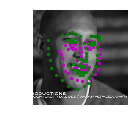

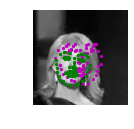

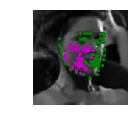

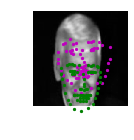

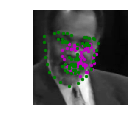

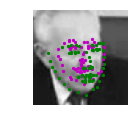

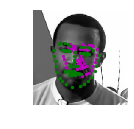

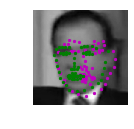

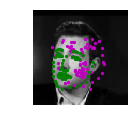

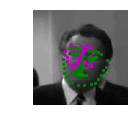

In [49]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [50]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I tried a few and found one that worked

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started out with one covolutional layer and added more layers to improve accuracy. I used a dropout layer to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.07693114 -0.03799754  0.08040076  0.04770454 -0.15673535]
 [-0.15075426  0.03974834 -0.03994096 -0.13204113  0.0153334 ]
 [ 0.15145668 -0.08449368  0.14479734 -0.14521824 -0.16486746]
 [-0.18019114  0.01963847 -0.13191226  0.08506554 -0.16083582]
 [-0.06930967 -0.11263325  0.0690665  -0.06679903 -0.04686923]]
(5, 5)


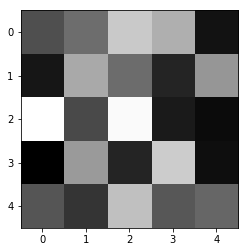

In [39]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 31

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [43]:
##TODO: load in and display any image from the transformed test dataset

image = test_images[0].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
plt.imshow(np.squeeze(image)
    
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


SyntaxError: unexpected EOF while parsing (<ipython-input-43-fdab3074f9c4>, line 9)

In [47]:
print(test_images[0].data.size)

<built-in method size of Tensor object at 0x11d5b1a20>


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!